In [1]:
import time

import jax
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.container import ErrorbarContainer
import numpy as np
from tqdm.notebook import tqdm, trange
from tueplots import bundles

from laurel import mdp, control
from oetils.plotting import init_plotting

In [2]:
plt.rcParams.update(bundles.neurips2023())
W = init_plotting(publish=True, W=plt.rcParams['figure.figsize'][0])
plt.rcParams.update({
    'grid.linestyle': ':',
    'legend.fancybox': False,
    'patch.linewidth': 0.5,
    'legend.edgecolor': 'inherit',
    'legend.framealpha': 0.8,
    'lines.linewidth': 1
})

In [3]:
nums_parcels = [10, 20, 50, 100, 200, 500, 1000]
num_trials = 5

rng = np.random.default_rng(42)
key = jax.random.PRNGKey(42)

In [4]:
# Initialize training MDP.
env = mdp.MiddleMileMDP(
    num_hubs=10,
    timesteps=50,
    num_trucks_per_step=10,
    max_truck_duration=5,
    num_parcels=nums_parcels,
    mean_route_length=10,
    unit_weights=True,
    unit_capacities=True,
)

# Training parameters
num_rollouts = 30
num_epochs = 5
num_feature_graph_steps = 3

# Train linear policy with supervised learning.
linear_controller = control.LinearSupervisedController(
    rng, key, env, num_rollouts, num_epochs
)
losses_linear = linear_controller.train()

# Train GNN policy with supervised learning.
gnn_controller = control.GNNSupervisedController(
    rng, key, env, num_rollouts, num_epochs, num_feature_graph_steps
)
losses_gnn = gnn_controller.train()

In [8]:
%debug

> /Users/onno/projects/laurel/laurel/control.py(321)collect_data()
    319 
    320         # Use truck and get next state.
--> 321         truck = trucks[label]
    322         state, *_ = self._env.step(
    323           parcel_state, truck, state, prune=self._step_prune

{16: 14, 18: 16, 180: 336}
{1039: [(6, 18), (6, 20), (5, 25), (6, 28), (6, 30), (6, 31), (5, 32), (7, 35), (7, 36), (7, 37), (2, 41), (2, 43), (2, 44), (4, 48), (4, 50)], 1040: [(3, 19), (0, 25)], 1041: [(6, 35), (6, 39), (4, 41), (4, 42)], 1042: [(5, 27), (7, 32), (5, 34), (7, 37)], 1043: [(4, 37), (0, 39), (5, 43)], 1044: [(3, 26), (5, 29), (3, 31), (0, 34), (2, 37), (0, 40)], 1045: [(9, 27), (2, 31)], 1046: [(6, 20), (6, 21), (4, 25), (0, 27), (0, 28), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (0, 39)], 1047: [(4, 23), (4, 24), (4, 25), (0, 27), (3, 30), (0, 33), (0, 34), (0, 35), (2, 38), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47)], 1048: [(7, 2), (5, 4)]}
*** NameError: name 'num_parcels' is not d

In [5]:
nums_hubs = [5, 10, 20, 50]
random_perf = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
greedy_perf = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
times = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))
iterations = np.zeros((len(nums_hubs), len(nums_parcels), num_trials))

for i, num_hubs in enumerate(tqdm(nums_hubs)):
  for j, num_parcels in enumerate(tqdm(nums_parcels, leave=False)):
    for k in range(num_trials):
      timesteps = 50
      num_trucks_per_step = num_hubs

      # Create middle-mile environment and initialize state.
      env = mdp.MiddleMileMDP(
          num_hubs=num_hubs,
          timesteps=timesteps,
          num_trucks_per_step=num_trucks_per_step,
          max_truck_duration=5,
          num_parcels=num_parcels,
          mean_route_length=10,
          unit_weights=True,
          unit_capacities=True,
      )
      init_state, _ = env.reset(rng)

      # Random
      start = time.time()
      state = init_state
      steps = 0
      deliveries = 0
      while True:
        steps += 1
        # Get next parcel and available trucks.
        state, parcel, trucks = env.get_actions(state, prune_parcel=False)
        if parcel is None:
          break

        # Put parcel onto random truck, get next state.
        truck = rng.choice(trucks)
        state, delivery, _ = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

      times[i, j, k] = time.time() - start
      iterations[i, j, k] = steps
      random_perf[i, j, k] = deliveries / num_parcels

      # Greedy
      state = init_state
      deliveries = 0
      while True:
        # Get next parcel and available trucks.
        state, feature_graph, parcel, trucks = env.get_feature_graph(
          1, state, min_phantom_weight=None, prune_parcel=False
        )
        if parcel is None:
          break
        parcel = parcel[0]

        # Put parcel truck, get next state.
        truck_ids = list(trucks.keys())
        truck = trucks[truck_ids[np.argmin(
          feature_graph.nodes[feature_graph.receivers[truck_ids]][:, 2]
        )]]
        state, delivery, _ = env.step(parcel, truck, state, prune=False)
        deliveries += delivery

      greedy_perf[i, j, k] = deliveries / num_parcels

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# Linear SL vs. GNN SL vs. Greedy vs. Random policies.
linear_perf = np.zeros((len(nums_parcels), num_trials))
gnn_perf = np.zeros((len(nums_parcels), num_trials))

for i, num_parcels in enumerate(tqdm(nums_parcels)):
    for j in trange(num_trials, leave=False):
        # Create middle-mile environment and initialize state.
        env = mdp.MiddleMileMDP(
            num_hubs=10,
            timesteps=50,
            num_trucks_per_step=10,
            max_truck_duration=5,
            num_parcels=num_parcels,
            mean_route_length=10,
            cut_capacities=0,
            unit_weights=True,
            unit_capacities=True,
        )
        init_state, _ = env.reset(rng)

        # Linear SL
        state = init_state
        deliveries = 0
        while True:
            # Get next parcel and available trucks.
            state, parcel, truck = linear_controller.act(state)
            if parcel is None:
                break

            # Put parcel onto truck, get next state.
            state, delivery, _ = env.step(parcel, truck, state, prune=False)
            deliveries += delivery

        linear_perf[i, j] = deliveries / num_parcels

        # GNN SL
        state = init_state
        deliveries = 0
        while True:
            # Get next parcel and available trucks.
            state, parcel, truck = gnn_controller.act(state)
            if parcel is None:
                break

            # Put parcel onto truck, get next state.
            state, delivery, _ = env.step(parcel, truck, state, prune=False)
            deliveries += delivery

        gnn_perf[i, j] = deliveries / num_parcels

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

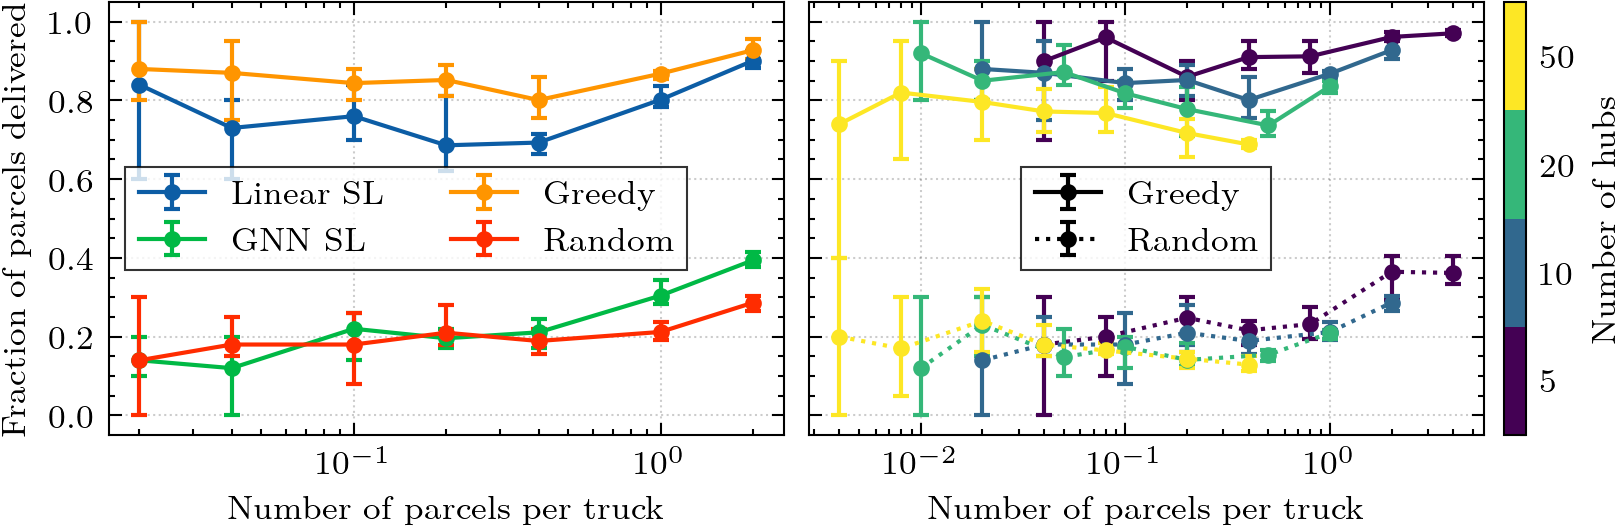

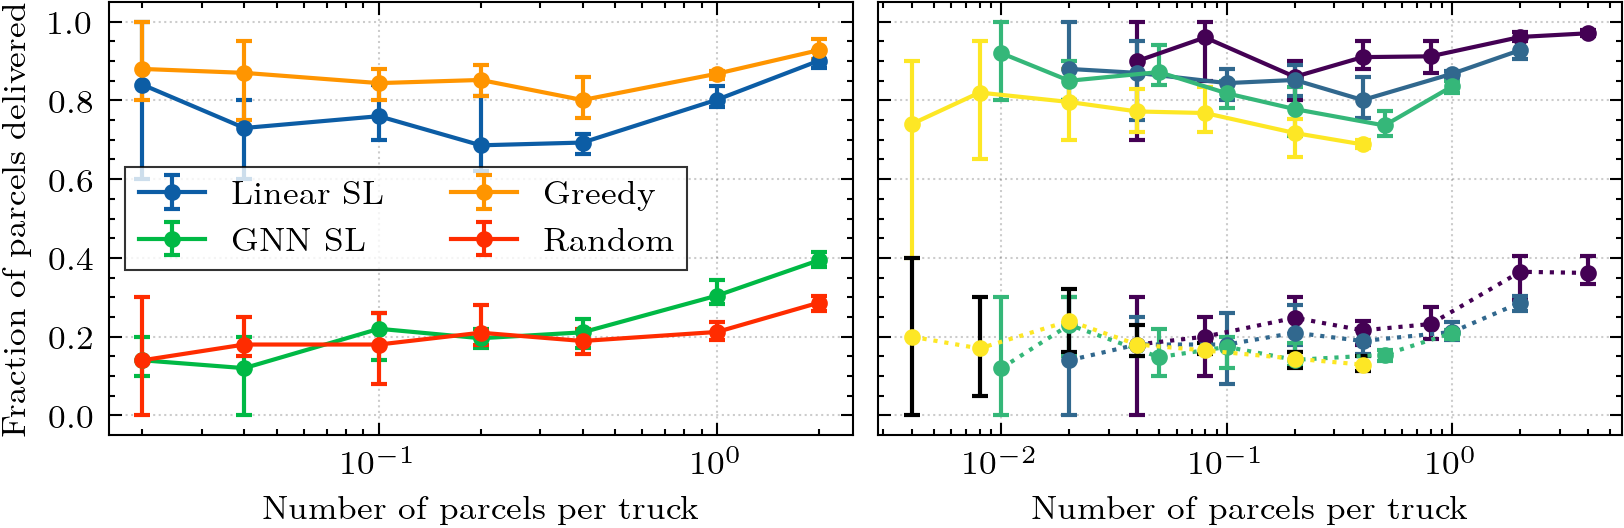

In [10]:
cmap = cm.viridis
norm = BoundaryNorm(range(len(nums_hubs) + 1), cmap.N)

# Plot performances.
fig, ax = plt.subplots(1, 2, figsize=(W, W/3), sharey=True)
ax[0].set_xlabel("Number of parcels per truck")
ax[0].set_ylabel("Fraction of parcels delivered")
ax[0].set_xscale('log')
ax[1].set_xlabel("Number of parcels per truck")
ax[1].set_xscale('log')

num_hubs = 10
parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(linear_perf, 1),
    np.stack([
        np.nanmean(linear_perf, 1) - np.nanmin(linear_perf, 1),
        np.nanmax(linear_perf, 1) - np.nanmean(linear_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Linear SL'
)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(gnn_perf, 1),
    np.stack([
        np.nanmean(gnn_perf, 1) - np.nanmin(gnn_perf, 1),
        np.nanmax(gnn_perf, 1) - np.nanmean(gnn_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'GNN SL'
)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(greedy_perf[1], 1),
    np.stack([
        np.nanmean(greedy_perf[1], 1) - np.nanmin(greedy_perf[1], 1),
        np.nanmax(greedy_perf[1], 1) - np.nanmean(greedy_perf[1], 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Greedy'
)
ax[0].errorbar(
    parcel_per_truck,
    np.nanmean(random_perf[1], 1),
    np.stack([
        np.nanmean(random_perf[1], 1) - np.nanmin(random_perf[1], 1),
        np.nanmax(random_perf[1], 1) - np.nanmean(random_perf[1], 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Random'
)
ax[0].legend(ncol=2)

for i, num_hubs in enumerate(nums_hubs):
    timesteps = 50
    parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
    ax[1].errorbar(
        parcel_per_truck,
        np.nanmean(greedy_perf[i], 1),
        np.stack([
            np.nanmean(greedy_perf[i], 1) - np.nanmin(greedy_perf[i], 1), 
            np.nanmax(greedy_perf[i], 1) - np.nanmean(greedy_perf[i], 1)
        ]),
        fmt='.-',
        color=cmap(norm(i)),
        capsize=2,
    )
for i, num_hubs in enumerate(nums_hubs):
    timesteps = 50
    parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
    ebc = ax[1].errorbar(
        parcel_per_truck,
        np.nanmean(random_perf[i], 1),
        np.stack([
            np.nanmean(random_perf[i], 1) - np.nanmin(random_perf[i], 1), 
            np.nanmax(random_perf[i], 1) - np.nanmean(random_perf[i], 1)
        ]),
        fmt=f'.:',
        color=cmap(norm(i)),
        capsize=2,
    )

# The copying will output multiple plots, but savefig only saves one plot.
from copy import deepcopy
_, caps, errs = deepcopy(ebc)
for cap in caps:
    cap.set_color('k')
for err in errs:
    err.set_color('k')
ebc1 = ErrorbarContainer((Line2D([],[], color='k', marker='.'), caps, errs), has_yerr=True, label='Greedy')
ebc2 = ErrorbarContainer((Line2D([],[], ls=':', color='k', marker='.'), caps, errs), has_yerr=True, label='Random')
ax[1].legend(handles=[ebc1, ebc2])

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], pad=0.03)
cbar.set_ticks(np.arange(len(nums_hubs)) + 0.5)
cbar.set_ticklabels(nums_hubs)
# cbar.ax.tick_params(length=2, width=0.5, direction='out')
cbar.set_label(r'Number of hubs')

fig.savefig('plot.pdf')

In [9]:
losses_gnn

array([6.96303177, 0.03302618, 0.02901889, 0.02755632, 0.02696594])

In [14]:
# Load supervised learning results.
gnn_perf = np.load('../out/sl_gnn_perf.npy')
linear_perf = np.load('../out/sl_linear_perf.npy')
greedy_perf = np.load('../out/sl_greedy_perf.npy')
random_perf = np.load('../out/sl_random_perf.npy')

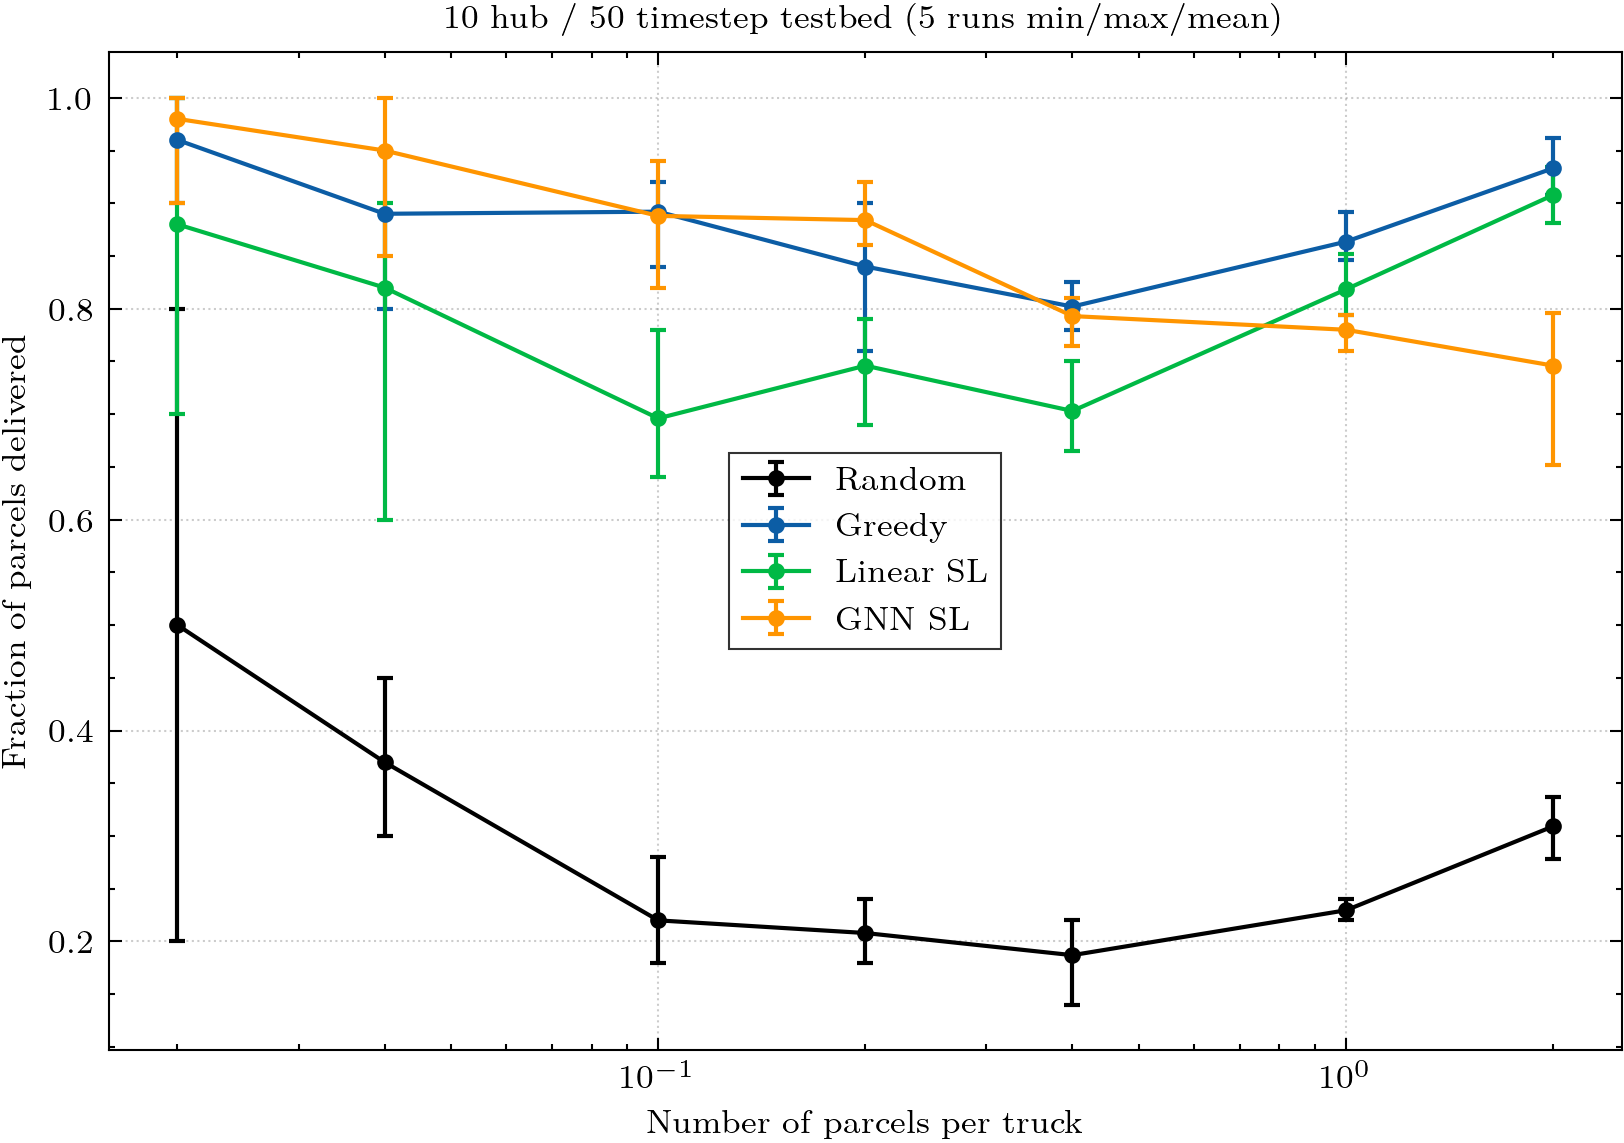

In [15]:
# Plot performances.
fig, ax = plt.subplots()
ax.set_title("10 hub / 50 timestep testbed (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels per truck")
ax.set_ylabel("Fraction of parcels delivered")
ax.set_xscale('log')
num_hubs = 10
timesteps = 50
parcel_per_truck = np.array(nums_parcels) / (num_hubs * timesteps)
ax.errorbar(
    parcel_per_truck,
    np.nanmean(random_perf, 1),
    np.stack([
        np.nanmean(random_perf, 1) - np.nanmin(random_perf, 1),
        np.nanmax(random_perf, 1) - np.nanmean(random_perf, 1)
    ]),
    fmt='k.-',
    capsize=2,
    label=f'Random'
)
ax.errorbar(
    parcel_per_truck,
    np.nanmean(greedy_perf, 1),
    np.stack([
        np.nanmean(greedy_perf, 1) - np.nanmin(greedy_perf, 1),
        np.nanmax(greedy_perf, 1) - np.nanmean(greedy_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Greedy'
)
ax.errorbar(
    parcel_per_truck,
    np.nanmean(linear_perf, 1),
    np.stack([
        np.nanmean(linear_perf, 1) - np.nanmin(linear_perf, 1),
        np.nanmax(linear_perf, 1) - np.nanmean(linear_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'Linear SL'
)
ax.errorbar(
    parcel_per_truck,
    np.nanmean(gnn_perf, 1),
    np.stack([
        np.nanmean(gnn_perf, 1) - np.nanmin(gnn_perf, 1),
        np.nanmax(gnn_perf, 1) - np.nanmean(gnn_perf, 1)
    ]),
    fmt='.-',
    capsize=2,
    label=f'GNN SL'
)
ax.legend()

In [16]:
a = []
b = np.arange(8)
a.extend(b)
a

[0, 1, 2, 3, 4, 5, 6, 7]

In [2]:
import numpy as np
np.inf * 0

nan